## 0. loading all necessary packages

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
import os
import sys
import geopandas
from fiona.crs import from_epsg
import pysal as ps
import seaborn as sns
import json
import pylab as pl
import pandas as pd
import re

#from PIL import Image
import zipfile
import sklearn.cluster
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from IPython.display import Image
s = json.load( open(os.getenv('PUIDATA')+'/fbb_matplotlibrc.json') )
pl.rcParams.update(s)

import os
import sys
print (os.getenv("PUIDATA"))

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


/home/cusp/ss9558/PUIdata


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## 1. get and prep your data.

In [11]:
!for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

!for ((y=0; y<=1; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\totals.zip; done

!for ((y=2; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

!for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

--2016-12-13 14:52:28--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp93totals.zip
           => “zbp93totals.zip”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Econ2001_And_Earlier/CBP_CSV ... done.
==> SIZE zbp93totals.zip ... done.
==> PASV ... done.    ==> RETR zbp93totals.zip ... 
No such file “zbp93totals.zip”.

--2016-12-13 14:52:29--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp94totals.zip
           => “zbp94totals.zip”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Econ2001_And_Earlier/CBP_CSV ... done.
==> SIZE zbp94totals.zip ... 611524
==> PASV ... don

In [12]:
#Download NYC Zip Codes Shape File
#Source: http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981
#Copy of the geojson file saved to PUIData
filename = "nyc-zip-code-tabulation-areas-polygons.geojson"
#os.system("mv " + filename + " " + os.getenv("PUIDATA"))
NYCZipCodes = geopandas.read_file(os.getenv("PUIDATA") + "/" + filename)
NYCZip = NYCZipCodes[['geometry', 'postalCode']]
NYCZip.rename(columns={'postalCode':'ZIP'}, inplace=True)
NYCZip['ZIP'] = NYCZip['ZIP'].astype(str)
NYCZip.head()
#NYCZip.shape

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,geometry,ZIP
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [14]:
#Merge census data to one data frame; remove zips with no info
path = os.getenv("PUIDATA") + "/CensusBusinessData/"
mydata = []
year1 = ['94', '95', '96', '97']
for yr in year1:
    filename = 'zbp' + yr + 'totals.zip'
    zf = zipfile.ZipFile(path + filename)
    df = pd.read_csv(zf.open(filename.replace('.zip','.txt')),
        index_col = [0],
        usecols = ['zip','est'])
    df.rename(columns = {'est': yr}, inplace=True)
    mydata.append(df)

In [15]:
year2 = ['98', '99', '00', '01', '02']
for yr in year2:
    filename = 'zbp' + yr + 'totals.zip'
    zf = zipfile.ZipFile(path + filename)
    df = pd.read_csv(zf.open(filename.replace('.zip','.txt')),
        index_col = [0],
        usecols = ['ZIP','EST'])
    df.rename(columns = {'EST': yr}, inplace=True)
    mydata.append(df)

In [16]:
year3 = ['03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14']
for yr in year3:
    filename = 'zbp' + yr + 'totals.zip'
    zf = zipfile.ZipFile(path + filename)
    df = pd.read_csv(zf.open(filename.replace('.zip','.txt')),
        index_col = [0],
        usecols = ['zip','est'])
    df.rename(columns = {'est': yr}, inplace=True)
    mydata.append(df)

In [17]:
bizData = mydata[0]
for i in np.arange(len(mydata) -1) + 1:
    bizData = pd.merge(bizData, mydata[i], left_index=True, right_index=True, how='inner')
bizData.head()

,94,95,96,97,98,99,00,01,02,03,...,05,06,07,08,09,10,11,12,13,14
1001,439,439,433,457,444,469,493,490,490,505,...,509,509,503,477,458,448,436,453,439,458
1002,450,467,487,500,490,558,563,587,566,586,...,589,582,596,584,571,570,558,572,572,560
1003,10,10,13,15,14,13,13,13,15,16,...,12,12,16,17,16,16,16,15,15,18
1004,47,48,47,41,31,35,48,37,23,21,...,31,30,20,18,18,21,19,16,16,13
1005,92,95,101,104,95,82,86,90,94,93,...,94,98,106,97,87,96,91,94,97,97


In [18]:
df_sd = bizData.std(axis = 1)
df_mean = bizData.mean(axis = 1)

for cols in bizData.columns:
    bizData[cols] = (bizData[cols] - df_mean) / df_sd

In [20]:
bizData['ZIP'] = bizData.index.astype(str)
bizData.shape

(35885, 22)

In [21]:
#merge
zipbizdata = pd.merge(bizData, NYCZip, how='inner', on=['ZIP'])
zipbizdata.head()

,94,95,96,97,98,99,00,01,02,03,...,07,08,09,10,11,12,13,14,ZIP,geometry
0,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,10001,POLYGON ((-74.00827017711134 40.75258714368449...
1,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,10002,POLYGON ((-73.97441674489379 40.73642441865476...
2,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,10003,POLYGON ((-73.97986374196766 40.73497446573838...
3,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,10004,"POLYGON ((-74.00596661578348 40.7043243225291,..."
4,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,10004,POLYGON ((-74.04166368343016 40.69644987183209...


In [41]:
year=[1994]
for i in range(1,21):
    t=1994+i
    year.append(t)

[1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014]

In [42]:
df = zipbizdata
#df.drop(['ZIP', 'geometry'], axis=1, inplace=True)
df.columns = year
df.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,0.432324,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986
1,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.522100,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077
2,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.127855,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833
3,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945
4,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945


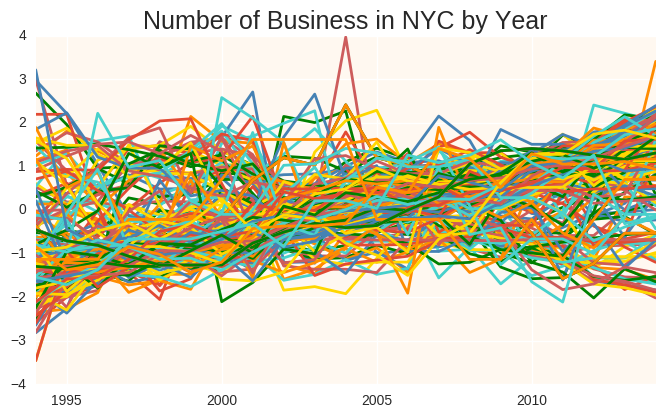

In [64]:
# expolre the data on plot
pl.figure(figsize=(8,4.5))
pl.xlim(1994,2014)
pl.title("Number of Business in NYC by Year", fontsize = 18)
for i in range(len(df)):
    pl.plot(df.iloc[i])

In [82]:
col= [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    ]

for 2 clusters, the number of lines in each clusters is [50, 193]


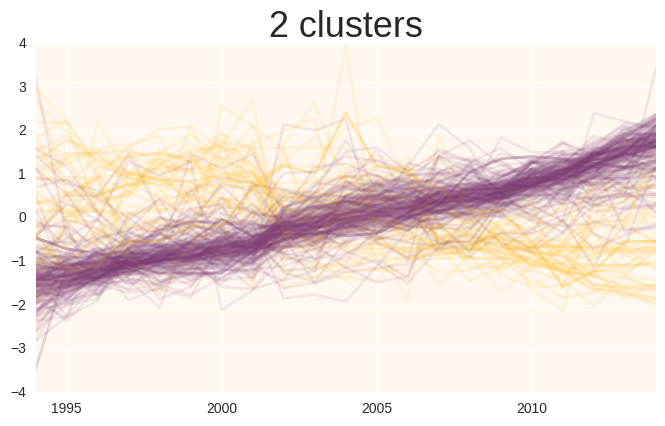

In [76]:
num_cluster = 2
clf=sklearn.cluster.KMeans(n_clusters = num_cluster)
clf.fit(df.values)
labels=clf.labels_
centers = clf.cluster_centers_
pl.figure(figsize=(8,4.5))
pl.xlim(1994,2014)
pl.title('%d clusters'%(num_cluster))
for i in range(len(df)):
        pl.plot(df.iloc[i],c=col[labels[i]], alpha=0.1)
mum_intercluster=[]
for j in range(num_cluster):
    #pl.plot(range(1994,2014),centers[j],'-',linewidth=5)
    pl.plot(centers[j],'-',c=col[j],linewidth=5)
    mum_intercluster.append(len([i for i in labels if i == j]))
        
print "for %d clusters, the number of lines in each clusters is"%(num_cluster), mum_intercluster                                                                            

for 3 clusters, the number of lines in each clusters is [187, 32, 24]


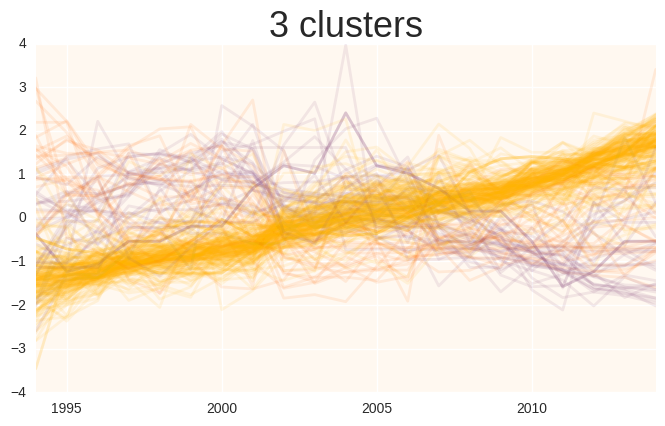

In [77]:
num_cluster = 3
clf=sklearn.cluster.KMeans(n_clusters = num_cluster)
clf.fit(df.values)
labels=clf.labels_
centers = clf.cluster_centers_
pl.figure(figsize=(8,4.5))
pl.xlim(1994,2014)
pl.title('%d clusters'%(num_cluster))
for i in range(len(df)):
        pl.plot(df.iloc[i],c=col[labels[i]], alpha=0.1)
mum_intercluster=[]
for j in range(num_cluster):
    #pl.plot(range(1994,2014),centers[j],'-',linewidth=5)
    pl.plot(centers[j],'-',c=col[j],linewidth=5)
    mum_intercluster.append(len([i for i in labels if i == j]))
        
print "for %d clusters, the number of lines in each clusters is"%(num_cluster), mum_intercluster                                                                            

for 4 clusters, the number of lines in each clusters is [16, 178, 32, 17]


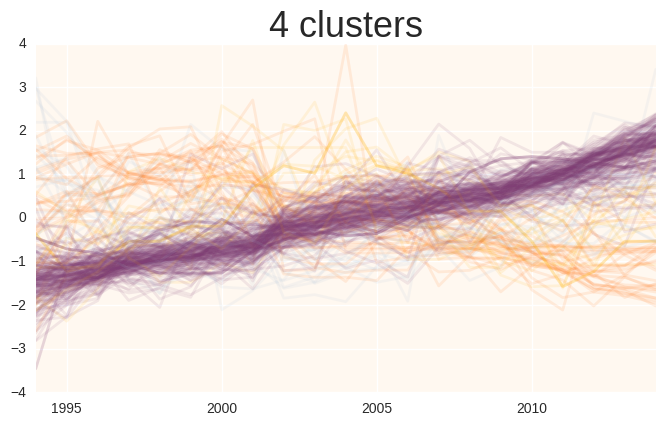

In [78]:
num_cluster = 4
clf=sklearn.cluster.KMeans(n_clusters = num_cluster)
clf.fit(df.values)
labels=clf.labels_
centers = clf.cluster_centers_
pl.figure(figsize=(8,4.5))
pl.xlim(1994,2014)
pl.title('%d clusters'%(num_cluster))
for i in range(len(df)):
        pl.plot(df.iloc[i],c=col[labels[i]], alpha=0.1)
mum_intercluster=[]
for j in range(num_cluster):
    #pl.plot(range(1994,2014),centers[j],'-',linewidth=5)
    pl.plot(centers[j],'-',c=col[j],linewidth=5)
    mum_intercluster.append(len([i for i in labels if i == j]))
        
print "for %d clusters, the number of lines in each clusters is"%(num_cluster), mum_intercluster                                                                            

for 5 clusters, the number of lines in each clusters is [133, 29, 17, 16, 48]


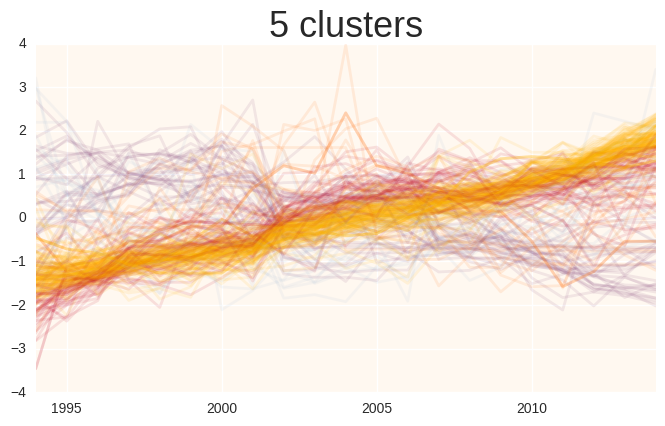

In [79]:
num_cluster = 5
clf=sklearn.cluster.KMeans(n_clusters = num_cluster)
clf.fit(df.values)
labels=clf.labels_
centers = clf.cluster_centers_
pl.figure(figsize=(8,4.5))
pl.xlim(1994,2014)
pl.title('%d clusters'%(num_cluster))
for i in range(len(df)):
        pl.plot(df.iloc[i],c=col[labels[i]], alpha=0.1)
mum_intercluster=[]
for j in range(num_cluster):
    #pl.plot(range(1994,2014),centers[j],'-',linewidth=5)
    pl.plot(centers[j],'-',c=col[j],linewidth=5)
    mum_intercluster.append(len([i for i in labels if i == j]))
        
print "for %d clusters, the number of lines in each clusters is"%(num_cluster), mum_intercluster                                                                            

In [80]:
# Agglomerative Clustering

def Aggcluster(num_cluster):
    
    #cluster
    clf=AgglomerativeClustering(n_clusters = num_cluster)
    clf.fit(df.values)
    labels=clf.labels_
    
    
    #plot
    pl.figure(figsize=(8,4.5))
    pl.xlim(1994,2013)
    pl.title('%d Clusters for Agglomerative Clustering'%(num_cluster))
    
    for i in range(len(df)):
        pl.plot(df.iloc[i], c=col[labels[i]], alpha=0.5)
        
    
    mum_intercluster=[]
    for j in range(num_cluster):
        mum_intercluster.append(len([i for i in labels if i == j]))
        
    print "for %d clusters, the number of lines in each clusters is"%(num_cluster), mum_intercluster

for 2 clusters, the number of lines in each clusters is [195, 48]
for 3 clusters, the number of lines in each clusters is [48, 180, 15]
for 4 clusters, the number of lines in each clusters is [180, 31, 15, 17]
for 5 clusters, the number of lines in each clusters is [31, 17, 15, 162, 18]


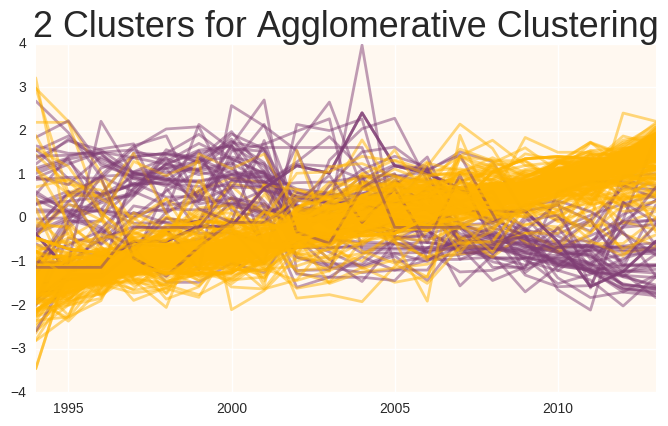

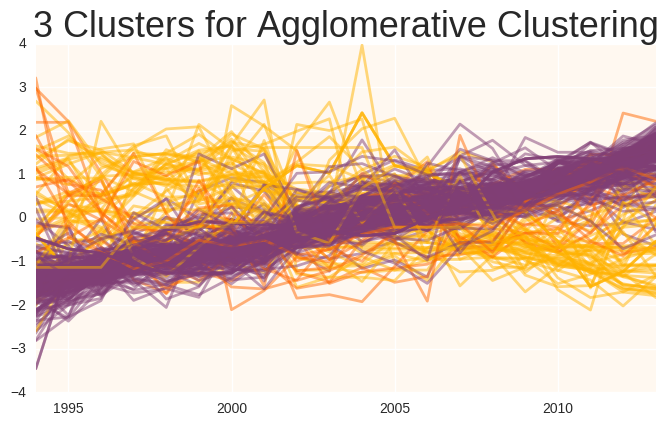

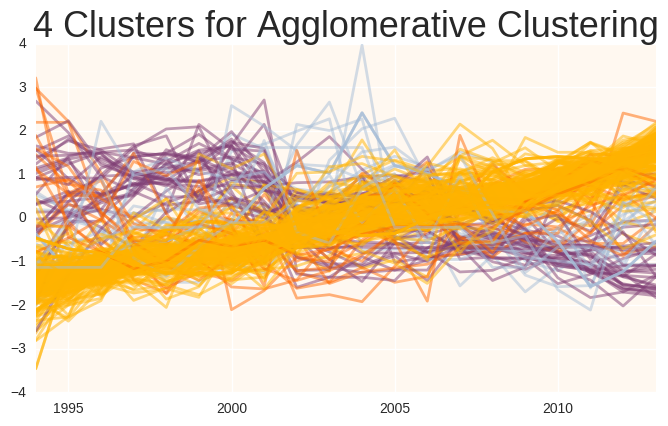

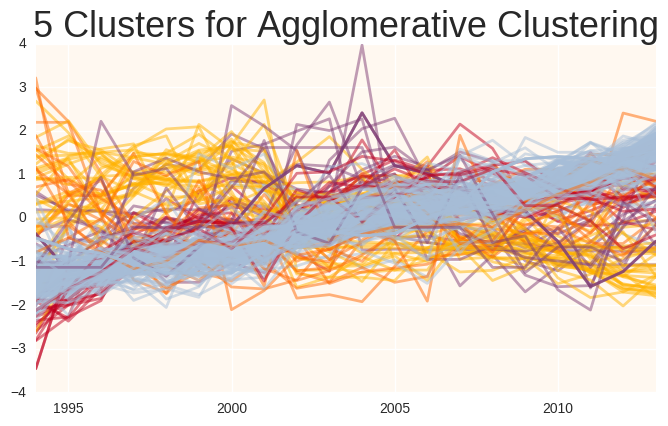

In [84]:
for i in range(2,6):
    Aggcluster(i)

AttributeError: Unknown property column

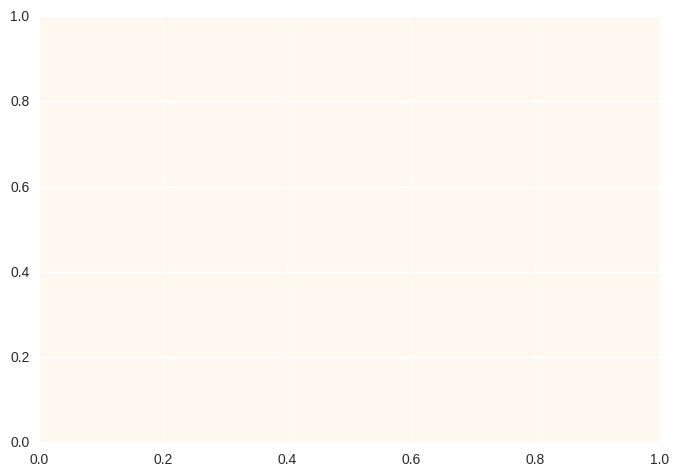

In [87]:
#10.5

#datafilefinal['label'] = resAP.labels_
#mapfileAP = datafilemap.merge(datafilefinal, on = 'zip')
plt.figure(figsize=(20, 16))
zipbizdata.plot(column='label', categorical=True, legend=True)
plt.title('Clusters of Number of Business in NYC by Affinity Propagation', fontsize = 18)

The two algorithms return similar results. In my opinion, the optimal number of cluster is 2 or 3 since they could clearly distinguish the bountry. When the number of cluster increased by 4 or 5, there is not much change.

Accorinding to the result,in the past 20 years and in most of areas in NYC, the number of establishments was keeping increasing. 

1. get and prep your data.
2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
4. Use another clustering algorithm (of your choice)
5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
6. Compare the results of the 2 algorithms
7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 